In [116]:
!pip install langchain openai langchain-experimental langchain-openai pillow open_clip_torch torch matplotlib --quiet

In [117]:
!pip install transformers --quiet

In [118]:
from langchain.vectorstores import SingleStoreDB
import os

from langchain_experimental.open_clip import OpenCLIPEmbeddings

os.environ["SINGLESTOREDB_URL"] = f'{connection_user}:{connection_password}@{connection_host}:{connection_port}/{connection_default_database}'

In [119]:
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"]='api_key_here'

In [157]:
vectorstore=SingleStoreDB(table_name="images2", embedding=OpenCLIPEmbeddings())

In [123]:
import requests

url = "https://tile.loc.gov/storage-services/service/pnp/fsa/8b29000/8b29500/8b29516v.jpg"
response = requests.get(url)

if response.status_code == 200:
    with open("downloaded_image.jpg", "wb") as f:
        f.write(response.content)
    print("Download successful. Image saved as 'downloaded_image.jpg'")
else:
    print(f"Failed to download the image. Status code: {response.status_code}")

Download successful. Image saved as 'downloaded_image.jpg'


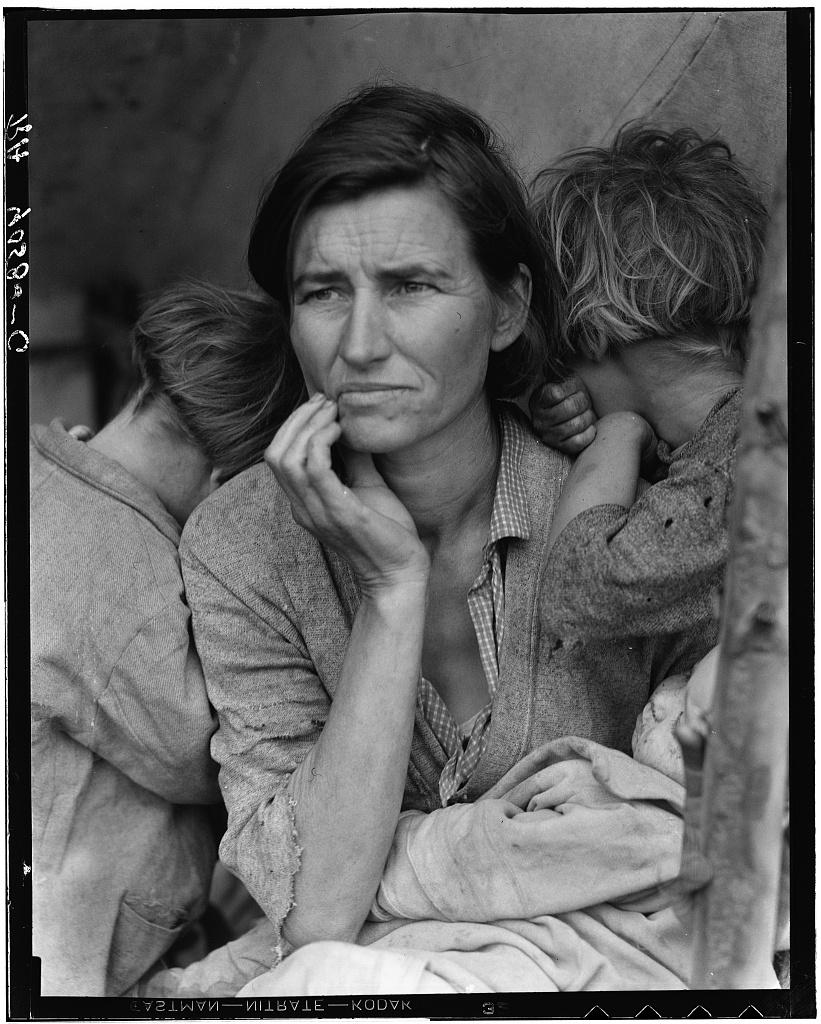

In [166]:
def plt_img_local(image_path):
    """Display image from a local file path"""
    # Display the image using IPython.display.Image
    display(Image(filename=image_path))

plt_img_local('downloaded_image.jpg')

In [167]:
vectorstore.add_images(uris=image_uris)

[]

In [169]:
query = "Show me an image with a woman and two children"
docs = vectorstore.similarity_search(query)
print(docs[0].page_content)

/home/jovyan/downloaded_image.jpg


In [179]:
import io
import re

from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

import base64

def encode_image_base64(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def get_image_urls(docs):
    """
    Split base64-encoded images
    """
    b64_images = []
    for doc in docs:
        b64 = encode_image_base64(doc.page_content)
        b64_images.append(b64)
        
    return {'images': b64_images}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for img_base64 in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"User-provided question: {data_dict['question']}\n\n"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(get_image_urls),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain

retriever = vectorstore.as_retriever()

chain_multimodal_rag = multi_modal_rag_chain(retriever)

In [180]:
query="Show me portrait pictures and describe them as a an expert photographer."
docs = retriever.get_relevant_documents(query=query)

In [183]:
chain_multimodal_rag.invoke(query)

"This is a black and white photograph that captures a poignant moment of a woman and her children. The composition is tight and intimate, focusing on the expressions and body language of the subjects. The woman's face is the central element of the image, with her gaze directed off-camera, suggesting contemplation or concern. Her furrowed brow, the slight frown, and the hand on her chin all contribute to a sense of worry or deep thought.\n\nThe children are turned away from the camera, their faces hidden, which adds a layer of privacy and protection. This choice directs the viewer's attention to the woman's expression and allows for speculation about the thoughts and emotions she might be experiencing.\n\nThe lighting is soft and appears to be natural, coming from one side, which creates a gentle contrast and gives depth to the subjects' features. The texture of the clothing, with visible wear and tear, adds to the storytelling, suggesting a life of hardship or struggle.\n\nThe depth of